In [103]:
# Use a pipeline as a high-level helper
from transformers import pipeline
import transformers
import os
import re
os.chdir("/u/li19/MMMU")
from datasets import load_dataset, concatenate_datasets
from mmmu.utils.data_utils import (
    load_yaml,
    construct_prompt,
    save_json,
    process_single_sample,
    CAT_SHORT2LONG,
)
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt

In [104]:
# Load dataset for each subject
sub_dataset_list = []
split = "validation"
for subject in tqdm(list(CAT_SHORT2LONG.values())):
    sub_dataset = load_dataset("MMMU/MMMU", subject, split=split)
    sub_dataset_list.append(sub_dataset)

# Merge all datasets
dataset = concatenate_datasets(sub_dataset_list)
device = "cuda:0"

  0%|          | 0/30 [00:00<?, ?it/s]

# Textual NoOps

## Substitution Code

In [ ]:
icl_examples = [
    {
        "subject": "finance",
        "old": "Without referring to the preprogrammed function on your financial calculator, use the basic formula for present value, along with the given opportunity cost, r, and the number of periods, n, to calculate the present value of $1 in case C shown in the following table. <image 1>",
        "new": "Without referring to the preprogrammed function on your financial calculator, use the basic formula for present value, along with the given opportunity cost, r, and the number of periods, n, to calculate the present value of $1 in case C shown in the following table, where the calculation will be performed on a sunny afternoon with a gentle breeze. <image 1>",
    },
    {
        "subject": "mechanical engineering",
        "old": "Car A travels at a constant speed of 65 mi / hr. When in the position shown at time t = 0, car B has a speed of 25 mi / hr and accelerates at a constant rate of 0.1g along its path until it reaches a speed of 65 mi / hr, after which it travels at that constant speed. What is the steady-state position of car A with respect to car B?",
        "new": "Car A travels at a constant speed of 65 mi / hr. When in the position shown at time t = 0, car B has a speed of 25 mi / hr and accelerates at a constant rate of 0.1g along its path until it reaches a speed of 65 mi / hr, after which it travels at that constant speed; the road surface is dry and has a slight texture. What is the steady-state position of car A with respect to car B?",
    },
    {
        "subject" : "manage",
        "old": "The <image 1> is the Five Forces model. What is the joint function of these five forces?",
        "new": "The <image 1> is the Five Forces model, which was first introduced by Michael Porter in his Harvard Business Review article in 1979. What is the joint function of these five forces?",
    },
    {
        "subject": "sociology",
        "old": "According to <image 1>, in Asch's study on conformity, what contributed to the ability of subjects to resist conforming",
        "new": "According to <image 1>, in Asch's study on conformity, what contributed to the ability of subjects to resist conforming, with the majority of participants being right-handed individuals?",
    },
    {
        "subject": "manage",
        "old": "Graph 1 shows the number of unemployed (in thousands) over a five-month period, organized by level of education completed. <image 1> The difference between the number of unemployed high school graduates and the number of unemployed workers without a high school diploma was smallest in ______.",
        "new": "Graph 1 shows the number of unemployed (in thousands) over a five-month period, organized by level of education completed. The figure was made using pythons matplotlib library. <image 1> The difference between the number of unemployed high school graduates and the number of unemployed workers without a high school diploma was smallest in ______.",
    },
    {
        "subject": "Accounting",
        "old": "Choco's Chocolates incurs the following costs for the month: <image 1> What is the conversion cost?",
        "new": "Choco's Chocolates incurs the following costs for the month: <image 1> What is the conversion cost? Choco's specializes in dark chocolates",
    },
    {
        "subject": "Architecture and Engineering",
        "old": "Determine the vertical displacements at A of the pin-connected structure in Figure P9.31. Given: E = 200 GPa,  AAB = 1000 mm2 , and AAC = AAD = 500 mm2 . <image 1>",
        "new": "Determine the vertical displacements at A of the pin-connected structure in Figure P9.31 from a recent conference best paper submission. Given: E = 200 GPa,  AAB = 1000 mm2 , and AAC = AAD = 500 mm2 . <image 1>",
    }
    
]

In [6]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "meta-llama/Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map=device,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [7]:
msg_template = '''
You are tasked with augmenting questions by adding a single sentence of irrelevant detail. Follow these instructions precisely:

1. Add a single sentence that introduces a detail unrelated to solving or reasoning through the question.
2. This added sentence **must not** change the question's meaning, context, or solution. It should relate tangentially to the subject of the question but must not provide any useful information or affect the answer.
3. Ensure the **original text remains exactly identical** except for the addition of the irrelevant sentence.
4. Do not add, remove, or modify image tags (e.g., `<image 1>` or `<image 2>`). The number, type, and placement of all image tags must remain identical before and after augmentation.
5. Outside the added content, all punctuation, capitalization, formatting, and wording of the original question must remain unchanged.
6. The added sentence should not provide additional context or insight for solving the question; it should be distracting or irrelevant while still grammatically correct and coherent.

If you fail to meet any of these requirements, you must retry until all instructions are satisfied. Only respond with the adjusted question.
'''

per_question = "This question is about {}, the question is: {}"

messages = [
    {"role": "system", "content": "you are a research assistant AI who is helping with exparimentation and augmenting my dataset"},
    {"role": "user", "content": msg_template},
]

for example in icl_examples:
    example_prompt = {"role": "user", "content":per_question.format(example["subject"], example["old"])}
    system_reply = {"role": "assistant", "content": example["new"]}
    messages.append(example_prompt)
    messages.append(system_reply)
base_prompt = messages

In [24]:
def update_question(question, subject, subsubject, pipeline):
    per_question = "This question is about {}, the question is: {}"
    
    # Prepare the initial messages
    messages = base_prompt[:]
    messages.append({"role": "user", "content": per_question.format(subject, question)})

    # Define terminators
    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    
    def validate_output(original_question, generated_question):
        """
        Validates the generated question based on the following criteria:
        - The original question's text is fully preserved.
        - The number, order, and indices of image tags are identical.
        """
        # Check if original question text is fully preserved
        if original_question not in generated_question:
            return False, "Original question text was not fully preserved."

        # Check if original question text is fully preserved
        if len(original_question) - len(generated_question) > -10:
            return False, "enough novel text was not added"
        
        # Extract image tags from original and generated questions
        import re
        original_images = re.findall(r"<image \d+>", original_question)
        generated_images = re.findall(r"<image \d+>", generated_question)
        
        # Check if image tags match
        if original_images != generated_images:
            return False, "Image tags differ in number, order, or indices."
        
        # All checks passed
        return True, None

    # Generate the output
    outputs = pipeline(
        messages,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        pad_token_id=pipeline.tokenizer.eos_token_id
    )
    generated_text = outputs[0]["generated_text"][-1]['content']
    
    # Validate the generated question
    is_valid, issue = validate_output(question, generated_text)
    if not is_valid:
        # Regenerate the prompt with issue explanation
        retry_message = {
            "role": "user",
            "content": (
                f"The previous attempt failed. Issue: {issue}\n"
                f"Original question: {question}\n"
                f"Generated question: {generated_text}\n"
                "Please regenerate the question while adhering to the outlined requirements.\n"
                "Do not say you are sorry or reply with any text other than the new question, no comments no notes just the text"
            )
        }
        messages.append(retry_message)
        
        # Retry generation
        outputs = pipeline(
            messages,
            max_new_tokens=256,
            eos_token_id=terminators,
            do_sample=True,
            temperature=0.1,
            top_p=0.9,
            pad_token_id=pipeline.tokenizer.eos_token_id
        )
        return outputs[0]["generated_text"][-1]['content']
    
    # Return the valid generated question
    return generated_text

In [25]:
new_questions = {}
for sample in tqdm(dataset):
    question = sample['question']
    subject = " ".join(sample['id'].split("_")[1:-1])
    subsubject = sample['subfield']
    noop_question = update_question(question, subject, subsubject, pipeline)
    new_questions[sample['id']] = noop_question
    print(question)
    print(noop_question)
    print()

  0%|          | 0/900 [00:00<?, ?it/s]

<image 1> Baxter Company has a relevant range of production between 15,000 and 30,000 units. The following cost data represents average variable costs per unit for 25,000 units of production. If 30,000 units are produced, what are the per unit manufacturing overhead costs incurred?
<image 1> Baxter Company has a relevant range of production between 15,000 and 30,000 units. The following cost data represents average variable costs per unit for 25,000 units of production. If 30,000 units are produced, what are the per unit manufacturing overhead costs incurred, noting that the company's CEO has a fondness for classic literature.
<image 1> Baxter Company has a relevant range of production between 15,000 and 30,000 units. The following cost data represents average variable costs per unit for 25,000 units of production. If 30,000 units are produced, what are the per unit manufacturing overhead costs incurred?
<image 1> Baxter Company has a relevant range of production between 15,000 and 30,

KeyboardInterrupt: 

In [12]:
new_questions

{'validation_Accounting_1': "I apologize for the mistake. Here is another attempt:\n\nBaxter Company has a relevant range of production between 15,000 and 30,000 units. The following cost data represents average variable costs per unit for 25,000 units of production. If 30,000 units are produced, what are the per unit manufacturing overhead costs incurred, with the company's production facility located in a suburban area.",
 'validation_Accounting_2': "I apologize for the mistake. Here's another attempt:\n\nAssume accounts have normal balances, solve for the one missing account balance: Dividends. Equipment was recently purchased, so there is neither depreciation expense nor accumulated depreciation. <image 1>\n\nRegenerated question:\n\nAssume accounts have normal balances, solve for the one missing account balance: Dividends. Equipment was recently purchased, so there is neither depreciation expense nor accumulated depreciation. The company's financial reports are due soon. <image 1>

In [12]:
with open(f"mmmu-noop/mmmu_{split}_noop_recursive.json", 'w') as f:
    json.dump(new_questions, f)

In [13]:
print("Done")

Done


## Insertion code

In [105]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "meta-llama/Llama-3.1-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map=device,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


### String Insert

In [121]:
icl_examples = [
    {
        "subject": "finance",
        "question": "Without referring to the preprogrammed function on your financial calculator, use the basic formula for present value, along with the given opportunity cost, r, and the number of periods, n, to calculate the present value of $1 in case C shown in the following table. <image 1>",
        "noop": "where the calculation will be performed on a sunny afternoon with a gentle breeze.",
        "location" : "table"
    },
    {
        "subject": "Accounting",
        "question": "Choco's Chocolates incurs the following costs for the month: <image 1> What is the conversion cost?",
        "noop": "Choco's specializes in dark chocolates",
        "location" : "cost"
    },
    {
        "subject": "Architecture and Engineering",
        "question": "Determine the vertical displacements at A of the pin-connected structure in Figure P9.31. Given: E = 200 GPa,  AAB = 1000 mm2 , and AAC = AAD = 500 mm2 . <image 1>",
        "noop": "from a recent conference best paper submission.",
        "location" : "P9.31"
    }
]

In [122]:
msg_template = '''
You are tasked with augmenting questions by adding a single sentence of irrelevant detail. Follow these instructions precisely:
- you are going to write a sentence that does not affect the answer to the question.
- this sentence will relate to the question and its subject but will not affect the answer.
- this sentence will be added to the question where you decide.
- the sentence will be inserted at the first occurance of the last word, pick a word that only occurs once or that you want to use the first occurance of.
- the sentence should be medium in length, up to two sentences but no more.
- pick a last word that is unique or at least rare in the question to avoid confusion.
- use the entire word and any punctuation when selecting the last word.
- this word will be matched to any word it is a substring of.

- please write your reply with the following format:
> last word of the previous sentence where this should be inserted.
> sentence to insert.

do not add any commentary or notes, this is going to be parsed with code so anything you write other than the sentence and
the location with the exact format describe above you will be made to re try.
'''

per_question = "This question is about {}, the question is: {}"
pre_reply = "> {}\n> {}"

messages = [
    {"role": "system", "content": "you are a research assistant AI who is helping with exparimentation and augmenting my dataset"},
    {"role": "user", "content": msg_template},
]

for example in icl_examples:
    example_prompt = {"role": "user", "content":per_question.format(example["subject"], example["question"])}
    system_reply = {"role": "assistant", "content": pre_reply.format(example['location'], example['noop'])}
    messages.append(example_prompt)
    messages.append(system_reply)
base_prompt = messages

In [108]:
def insert_string_after_first_full_word_no_image_break(original_str, target_word, insert_str):
    """
    Inserts `insert_str` immediately after the FIRST full-word occurrence of
    `target_word` in `original_str`, preserving any existing <image n> tags
    in `original_str` (returning them unchanged) and removing any <image n>
    tags from `insert_str`.

    If `target_word` does not appear as a full word, then `insert_str` is
    appended at the end of `original_str`.
    """

    # 1) Strip out any <image n> in `insert_str`
    sanitized_insert_str = re.sub(r"<image\s*\d+>", "", insert_str)

    # 2) Compile a pattern that matches EITHER an <image n> tag OR the target_word as a full word
    pattern = re.compile(
        r"<image\s*\d+>"                       # match & preserve existing <image n>
        r"|(\b" + re.escape(target_word) + r"\b)"  # or match target_word fully
    )

    # Use a flag to track whether we've already inserted once.
    inserted = False

    def replacer(match):
        """
        If it's <image n>, return unchanged.
        If it's the target_word and we haven't inserted yet,
        append the sanitized insertion string.
        """
        nonlocal inserted

        if match.group(0).startswith("<image"):
            # Preserve the <image n> tag as-is
            return match.group(0)
        else:
            # It's the target_word => insert if not already inserted
            if not inserted:
                inserted = True
                return match.group(0) + sanitized_insert_str
            else:
                return match.group(0)

    # 3) Perform the substitution across the entire string.
    result = pattern.sub(replacer, original_str)

    # 4) If we never matched and inserted (i.e., `target_word` not found), append at the end.
    if not inserted:
        result += sanitized_insert_str

    return result

In [109]:
def insert_noop(original_str, target_word, insert_str):
    sanitized_insert_str = re.sub(r"<image\s*\d+>", "", insert_str)

    # 2) Compile a pattern that matches EITHER an <image n> tag OR the target_word as a full word.
    pattern = re.compile(
        r"<image\s*\d+>"                       # match and preserve existing <image n>
        r"|(\b" + re.escape(target_word) + r"\b)"  # or match target_word fully
    )

    # Use a flag to track whether we've already inserted once.
    inserted = False

    def replacer(match):
        """
        If it's <image n>, return unchanged.
        If it's the target_word and we haven't inserted yet, append the sanitized insertion string.
        Otherwise, if we've already inserted, just return the word unchanged.
        """
        nonlocal inserted

        if match.group(0).startswith("<image"):
            # Preserve the <image n> tag as-is
            return match.group(0)
        else:
            # This must be the target_word
            if not inserted:
                # First time we see the target_word => insert
                inserted = True
                return match.group(0) + sanitized_insert_str
            else:
                # Already inserted once => do nothing more
                return match.group(0)

    # 3) Replace all matches, but effectively insert only once due to the `inserted` flag
    return pattern.sub(replacer, original_str)

def parse_insert_gen(content):
    # print("parse: \n", content)
    noop, location = content.split("\n")
    noop = noop.replace(">","")
    location = location.replace(">","")
    return noop, location

def update_question(question, subject, subsubject, pipeline):
    per_question = "This question is about {}, the question is: {}"
    
    # Prepare the initial messages
    messages = base_prompt[:]
    messages.append({"role": "user", "content": per_question.format(subject, question)})

    # Define terminators
    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    # Generate the output
    outputs = pipeline(
        messages,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        pad_token_id=pipeline.tokenizer.eos_token_id
    )

    noop, insert_token = parse_insert_gen(outputs[0]["generated_text"][-1]['content'])

    generated_question = insert_noop(question, insert_token, noop)

    return generated_question

### Sentence Insert

In [113]:
import re
import string

In [134]:
def split_into_sentences(text):
    """
    Splits `text` into sentences at ., ?, ! (including the punctuation).
    Returns a list of sentences with trailing punctuation (if present).
    """
    # Regex explanation:
    #   (?:\.|\?|!) - a non-capturing group matching ., ?, or !
    #   (?=\s|$)    - lookahead ensuring we split only when punctuation is followed by whitespace or end of text
    # We also handle multiple spaces or newline after punctuation.
    pattern = r'(?<=[.?!])\s+'
    sentences = re.split(pattern, text.strip())
    return [s.strip() for s in sentences if s.strip()]

def ends_with_word_ignoring_punc(sentence, target_word):
    """
    Returns True if `sentence` ends with `target_word` ignoring punctuation.
    Example:
      sentence = "I love cost?"
      target_word = "cost"
      => True
    """
    # 1) Strip trailing spaces
    sent_stripped = sentence.strip()
    
    # 2) Remove trailing punctuation from the end of the sentence
    #    so if the sentence ends with cost? or cost., we remove them
    while len(sent_stripped) > 0 and sent_stripped[-1] in string.punctuation:
        sent_stripped = sent_stripped[:-1]
    
    # 3) Now split by spaces and get the very last token
    tokens = sent_stripped.split()
    if not tokens:
        return False
    last_token = tokens[-1].lower()
    
    # 4) Remove punctuation from `target_word` too
    tw = target_word.strip()
    while len(tw) > 0 and tw[-1] in string.punctuation:
        tw = tw[:-1]
    tw = tw.lower()
    
    # 5) Compare
    return last_token == tw


def insert_sentence_after_ending_word(original_text, target_word, new_sentence):
    """
    - Splits `original_text` into sentences by . ? !
    - Finds the FIRST sentence that ends with `target_word` (ignoring punctuation).
    - Inserts `new_sentence` as a brand-new sentence after it.
    - If no match is found, appends `new_sentence` at the end of the entire text.
    """
    sentences = split_into_sentences(original_text)
    if not sentences:
        # If there's no actual sentence, just return the new sentence appended
        return (original_text + " " + new_sentence).strip()

    inserted = False
    new_sentences = []

    for i, s in enumerate(sentences):
        new_sentences.append(s)
        if not inserted and ends_with_word_ignoring_punc(s, target_word):
            # Insert the new sentence RIGHT AFTER this sentence
            new_sentences.append(new_sentence.strip())
            inserted = True

    if not inserted:
        # If never inserted, place at the end
        new_sentences.append(new_sentence.strip())
    
    # Join them with a space or newline. Typically, you might want a space:
    # But if you need normal punctuation rules, you can do something more advanced.
    return " ".join(new_sentences)

In [135]:
msg_template = '''
You are tasked with augmenting questions by adding a standalone irrelevant sentence. Follow these instructions precisely:
- You will write one complete sentence that does not affect the answer to the question.
- That new sentence can be up to two sentences in length, but keep it short and irrelevant.
- Then choose the last word of the sentence before which you will insert this new sentence.
- Make sure that "last word" refers to the final word in that sentence—punctuation can be ignored in matching.
- Use this format exactly (no extra commentary):
> last word of the preceding sentence where this should be inserted
> your new sentence here.
'''
per_question = "This question is about {}, the question is: {}"
pre_reply = "> {}\n> {}"

messages = [
    {"role": "system", "content": "you are a research assistant AI who is helping with exparimentation and augmenting my dataset"},
    {"role": "user", "content": msg_template},
]

for example in icl_examples:
    example_prompt = {"role": "user", "content":per_question.format(example["subject"], example["question"])}
    system_reply = {"role": "assistant", "content": pre_reply.format(example['location'], example['noop'])}
    messages.append(example_prompt)
    messages.append(system_reply)
base_prompt = messages

In [141]:
def parse_insert_gen(content):
    # print("parse: \n", content)
    location, noop = content.split("\n")
    noop = noop.replace(">","")
    location = location.replace(">","")
    return location, noop

def update_question_sent(question, subject, subsubject, pipeline):
    per_question = "This question is about {}, the question is: {}"
    
    # Prepare the initial messages
    messages = base_prompt[:]
    messages.append({"role": "user", "content": per_question.format(subject, question)})

    # Define terminators
    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    # Generate the output
    outputs = pipeline(
        messages,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        pad_token_id=pipeline.tokenizer.eos_token_id
    )
    try:
        insert_token, noop = parse_insert_gen(outputs[0]["generated_text"][-1]['content'])
        generated_question = insert_sentence_after_ending_word(question, insert_token, noop)
    except Exception as e: 
        print(question)
        print(outputs[0]["generated_text"][-1]['content'])
        print(e)
        generated_question = question

    return generated_question

### Question Update

In [142]:
new_questions = {}
for sample in tqdm(dataset):
    question = sample['question']
    subject = " ".join(sample['id'].split("_")[1:-1])
    subsubject = sample['subfield']
    # noop_question = update_question(question, subject, subsubject, pipeline)
    noop_question = update_question_sent(question, subject, subsubject, pipeline)
    new_questions[sample['id']] = noop_question

  0%|          | 0/900 [00:00<?, ?it/s]

The maximum flow from v1 to v6 is ____: <image 1>
> ____
not enough values to unpack (expected 2, got 1)


In [143]:
with open(f"mmmu-noop/mmmu_{split}_noop_insert_sentence.json", 'w') as f:
    json.dump(new_questions, f)

## Update

In [18]:
# # Load dataset for each subject
# sub_dataset_list = []
# split = "validation"
# for subject in tqdm(list(CAT_SHORT2LONG.values())):
#     sub_dataset = load_dataset("MMMU/MMMU", subject, split=split)
#     sub_dataset_list.append(sub_dataset)

# # Merge all datasets
# dataset = concatenate_datasets(sub_dataset_list)
# with open(f"mmmu-noop/mmmu_{split}_noop_fixed.json", 'r') as f:
#     old_noop = json.load(f)

In [20]:
replacements = {}
for sample in tqdm(dataset):
    pattern = r"<image (?:10|[0-9])>"
    uid = sample['id']
    noop = new_questions[uid]
    real = sample['question']
    realm = re.findall(pattern, real)
    noopm = re.findall(pattern, noop)
    fixing = realm != noopm

    if fixing:
        print(uid)
        print()
        fixing = False
        i = 0
    while fixing:
        question = sample['question']
        subject = " ".join(sample['id'].split("_")[1:-1])
        subsubject = sample['subfield']
        new_noop = update_question(question, subject, subsubject, pipeline)
        noopm = re.findall(pattern, new_noop)
        fixing = realm != noopm
        if not fixing:
            print("FIXED: ", uid)
            replacements[uid] = new_noop
        else:
            i += 1
            print(i)
            if i > 25:
                print("Could not resolve: ", uid)
                fixing = False
    

  0%|          | 0/900 [00:00<?, ?it/s]

validation_Agriculture_21

validation_Agriculture_23

validation_Architecture_and_Engineering_28

validation_Art_12

validation_Art_29

validation_Art_Theory_1

validation_Basic_Medical_Science_27

validation_Biology_24

validation_Biology_29

validation_Clinical_Medicine_4

validation_Computer_Science_11

validation_Design_8

validation_Design_11

validation_Design_14

validation_Design_15

validation_Design_19

validation_Design_24

validation_Design_25

validation_Economics_1

validation_Economics_23

validation_Music_15

validation_Music_18

validation_Music_23

validation_Music_29

validation_Physics_3

validation_Physics_13

validation_Psychology_12

validation_Psychology_14

validation_Psychology_22

validation_Psychology_23

validation_Psychology_25

validation_Psychology_26

validation_Psychology_29

validation_Public_Health_26

validation_Sociology_3

validation_Sociology_13

validation_Sociology_19



In [22]:
replacements = {}
for sample in tqdm(dataset):
    pattern = r"<image (?:10|[0-9])>"
    uid = sample['id']
    noop = new_questions[uid]
    real = sample['question']
    if len(real) > len(noop):
        print(uid)

  0%|          | 0/900 [00:00<?, ?it/s]

validation_Agriculture_23
validation_Architecture_and_Engineering_30
validation_Clinical_Medicine_4
validation_Computer_Science_26
validation_Economics_16
validation_Energy_and_Power_18
validation_Finance_4
validation_Finance_21
validation_Manage_12
validation_Manage_16
validation_Manage_29
validation_Math_8
validation_Mechanical_Engineering_18
validation_Physics_2
validation_Psychology_11
validation_Psychology_12
validation_Psychology_14
validation_Psychology_22
validation_Psychology_23
validation_Psychology_25
validation_Psychology_26
validation_Psychology_29
validation_Public_Health_26


In [52]:
for el in old_noop:
    if el in replacements.keys():
        print("replaced: ", el) 
        old_noop[el] = replacements[el]

replaced:  validation_Biology_16
replaced:  validation_Chemistry_2
replaced:  validation_Chemistry_9
replaced:  validation_Clinical_Medicine_1
replaced:  validation_Clinical_Medicine_6
replaced:  validation_Clinical_Medicine_10
replaced:  validation_Clinical_Medicine_12
replaced:  validation_Clinical_Medicine_14
replaced:  validation_Clinical_Medicine_16
replaced:  validation_Clinical_Medicine_19
replaced:  validation_Clinical_Medicine_25
replaced:  validation_Clinical_Medicine_30
replaced:  validation_Computer_Science_2
replaced:  validation_Computer_Science_6
replaced:  validation_Computer_Science_8
replaced:  validation_Computer_Science_13
replaced:  validation_Computer_Science_19
replaced:  validation_Computer_Science_26
replaced:  validation_Computer_Science_30
replaced:  validation_Design_2
replaced:  validation_Design_4
replaced:  validation_Design_11
replaced:  validation_Design_13
replaced:  validation_Design_15
replaced:  validation_Design_18
replaced:  validation_Design_19
r

In [54]:
with open("fixed_noop.json", 'w') as f:
    json.dump(old_noop, f)

# Image NoOps

## Code

In [3]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import random

In [83]:
# Function to add a circle
def add_circle(draw, x1, y1, x2, y2, line_width):
    draw.ellipse([x1, y1, x2, y2], outline="blue", width=line_width)

# Function to add a rectangle
def add_rectangle(draw, x1, y1, x2, y2, line_width):
    draw.rectangle([x1, y1, x2, y2], outline="green", width=line_width)

# Function to add a triangle
def add_triangle(draw, coords, line_width):
    draw.polygon(coords, outline="red", width=line_width)

# Function to add text
def add_text(draw, x, y, text, font_size):
    font = ImageFont.load_default()
    draw.text((x, y), text, fill="purple", font=font)

# Function to adjust color globally
def adjust_color(image, shift_value):
    if image is None:
        return None
    return Image.eval(image, lambda x: max(0, min(255, x + shift_value)))

# Function to adjust color locally with Gaussian blur
def adjust_color_local(image, shift_value, region):
    if image is None:
        return None

    x1, y1, x2, y2 = region
    mask = Image.new("L", (x2 - x1, y2 - y1), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse([(0, 0), (x2 - x1, y2 - y1)], fill=255)
    mask = mask.filter(ImageFilter.GaussianBlur(radius=15))

    cropped_region = image.crop((x1, y1, x2, y2))
    adjusted_region = Image.eval(cropped_region, lambda x: max(0, min(255, x + shift_value)))

    image.paste(Image.composite(adjusted_region, image.crop((x1, y1, x2, y2)), mask), (x1, y1))
    return image

# Function to add a border with padding
def add_border_color(image, border_width, border_color, padding):
    if image is None:
        return None

    width, height = image.size
    new_width = width + 2 * padding
    new_height = height + 2 * padding

    temp_image = Image.new("RGBA", (width + 2 * padding, height + 2 * padding), border_color)
    temp_image.paste(image, (padding, padding))

    draw = ImageDraw.Draw(temp_image)
    draw.rectangle([0, 0, new_width - 1, border_width], fill="blue")
    draw.rectangle([0, new_height - border_width, new_width - 1, new_height - 1], fill="blue")
    draw.rectangle([0, 0, border_width, new_height - 1], fill="blue")
    draw.rectangle([new_width - border_width, 0, new_width - 1, new_height - 1], fill="blue")

    return temp_image


In [117]:

# Function to add visual no-ops based on weights
def add_visual_noops(image, no_ops=None, weights=None, no_op_idxs=None, random_seed=None):
    if image is None:
        return None
    if no_ops is None:
        no_ops = [add_circle, add_rectangle, add_triangle, add_text, adjust_color_local, add_border_color]
    if weights is None:
        weights = [1 / len(no_ops)] * len(no_ops)
    if random_seed is not None:
        random.seed(random_seed)

    image = image.convert("RGBA")
    draw = ImageDraw.Draw(image)
    width, height = image.size
    line_width = max(1, int(width * 0.03))
    font_size = max(10, int(width * 0.05))  # Set font size proportional to image width

    params = []
    if no_op_idxs is None:
        chosen_no_ops = random.choices(no_ops, weights=weights, k=random.randint(1, 3))
    else:
        chosen_no_ops = [no_ops[i] for i in no_op_idxs]

    for no_op in chosen_no_ops:
        if no_op == adjust_color:
            shift_value = random.randint(-10, 10)
            params.append(("adjust_color", shift_value))
            image = adjust_color(image, shift_value)
        
        elif no_op == adjust_color_local:
            region = (
                random.randint(0, width // 2),
                random.randint(0, height // 2),
                random.randint(width // 2, width),
                random.randint(height // 2, height)
            )
            shift_value = 50
            params.append(("adjust_color_local", shift_value, region))
            image = adjust_color_local(image, shift_value, region)
            
        elif no_op == add_border_color:
            border_width = line_width
            border_color = (255, 0, 0, 255)
            padding = line_width
            params.append(("add_border_color", border_width, border_color, padding))
            image = add_border_color(image, border_width, border_color, padding)
        
        elif no_op == add_circle:
            x1, y1 = random.randint(0, width // 2), random.randint(0, height // 2)
            x2, y2 = random.randint(width // 2, width), random.randint(height // 2, height)
            params.append(("add_circle", x1, y1, x2, y2, line_width))
            no_op(draw, x1, y1, x2, y2, line_width)
        
        elif no_op == add_rectangle:
            x1, y1 = random.randint(0, width // 2), random.randint(0, height // 2)
            x2, y2 = random.randint(width // 2, width), random.randint(height // 2, height)
            params.append(("add_rectangle", x1, y1, x2, y2, line_width))
            no_op(draw, x1, y1, x2, y2, line_width)
        
        elif no_op == add_triangle:
            coords = [(random.randint(0, width), random.randint(0, height)) for _ in range(3)]
            params.append(("add_triangle", coords, line_width))
            no_op(draw, coords, line_width)
        
        elif no_op == add_text:
            text = random.choice(["Note", "FYI", "!?!"])
            x, y = random.randint(0, width - 50), random.randint(0, height - 20)
            params.append(("add_text", x, y, text, font_size))
            no_op(draw, x, y, text, font_size)

    return image, params


## Testing

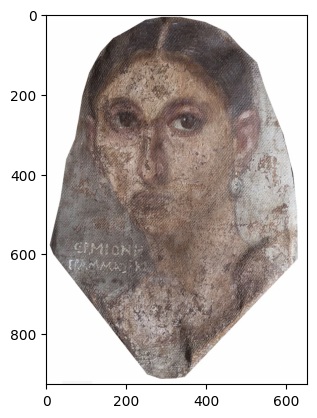

In [93]:
img = sample['image_1']
plt.imshow(img)

(127, 142, 415, 689)


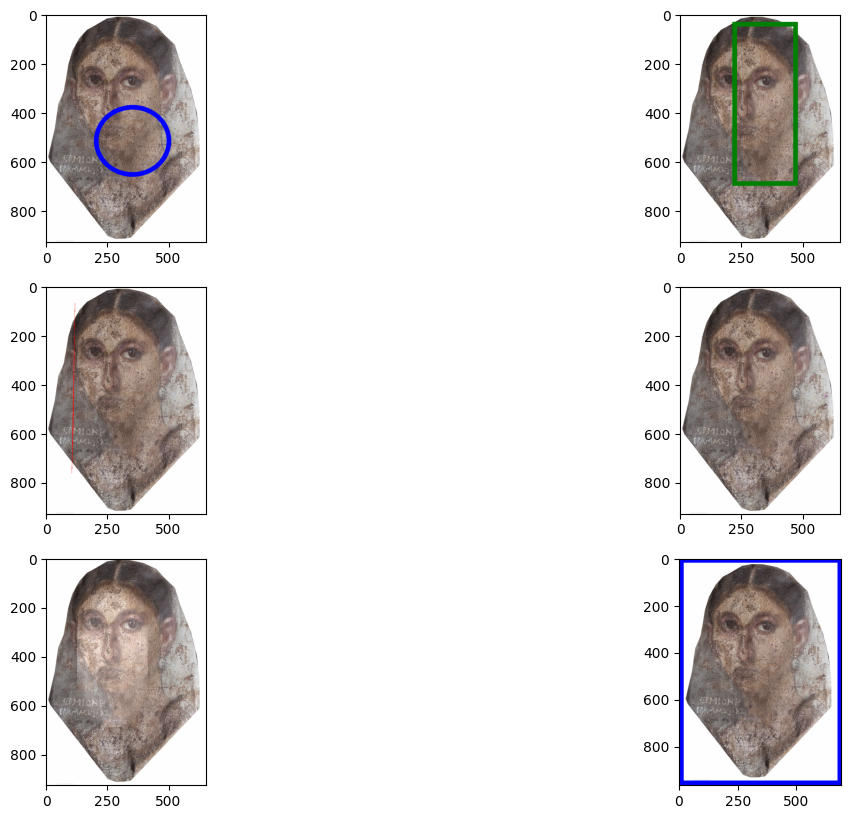

In [95]:
# Create two subplots and unpack the output array immediately
fig, axs = plt.subplots(3, 2, figsize=(15,10))

for i, ax in enumerate(axs.flatten()):
    # print(i)
    # new_img, params = add_visual_noops(img)
    new_img, params = add_visual_noops(img, no_op_idxs=[i])
    # print(new_img)
    ax.imshow(new_img)

## Generation

In [124]:
img_root = "/u/li19/data_folder/mmmu_NoOp_imgs"
data = {}
for sample in tqdm(dataset):
    qid = sample['id']
    path = os.path.join(img_root, qid)
    os.makedirs(path, exist_ok=True)
    image_names = [f"image_{n}" for n in range(1, 8)]
    imgs = [(name, sample[name]) for name in image_names if sample[name] is not None]

    metadata = {
        'path': path,
        'image_names': image_names[:len(imgs)],
        'image_paths': [] 
    }
    
    for name, img in imgs:
        img_path = os.path.join(path, name)
        new_img, conf = add_visual_noops(img, no_op_idxs=[4,5])
        new_img.save(img_path+".png")
        metadata['image_paths'].append(img_path)
    
    data[qid] = metadata

  0%|          | 0/900 [00:00<?, ?it/s]

In [125]:
with open("val_img_NoOp_metadata.json", 'w') as f:
    json.dump(data, f)

In [122]:
sample

{'id': 'validation_Sociology_30',
 'question': 'Who found evidence that <image 1> has been normalised?',
 'options': "['Postman', 'Oakley', 'Philips', 'Aries', 'Mithchel and Woodey']",
 'explanation': '',
 'image_1': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=820x400>,
 'image_2': None,
 'image_3': None,
 'image_4': None,
 'image_5': None,
 'image_6': None,
 'image_7': None,
 'img_type': "['Photographs']",
 'answer': 'E',
 'topic_difficulty': 'Hard',
 'question_type': 'multiple-choice',
 'subfield': 'Sociology Theory'}